In [26]:
#libraries
from minio import Minio
from minio.error import S3Error
import requests
from io import BytesIO
import time
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import pickle

In [27]:
def get_latest_zip_object():
    # Gets the latest ZIP from the bucket
    objects = client.list_objects(bucket_name, prefix=prefix, recursive=True)
    zip_objects = [obj for obj in objects if obj.object_name.endswith(".zip")]
    if not zip_objects:
        return None
    zip_objects.sort(key=lambda x: x.last_modified, reverse=True)
    return zip_objects[0]
def process_zip(zip_path,output):   #Extracts and processes the contents of the ZIP and saves the results to output/<zip_name>/
    # Temporary folder for extraction
    extract_dir = os.path.join(os.path.dirname(zip_path), "temp_extraction")
    os.makedirs(extract_dir, exist_ok=True)

    # Destination folder to save results
    zip_name = os.path.splitext(os.path.basename(zip_path))[0]
    output_dir = os.path.join("output", zip_name)
    os.makedirs(output_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    excel_file = None
    image_files = []
    for root, _, files in os.walk(extract_dir):
        for file in files:
            path = os.path.join(root, file)
            target_path = os.path.join(output_dir, file)
            # Copy extracted file to output_dir
            with open(path, 'rb') as src, open(target_path, 'wb') as dst:
                dst.write(src.read())

           # Sorting for display
            if file.endswith(".xlsx"):
                excel_file = target_path
            elif file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(target_path)
    # Show Excel
    if excel_file:
        xls = pd.ExcelFile(excel_file)
        print(f"Excel file in: {xls.sheet_names}")
        for sheet in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet)
            print(f"Sheet: {sheet}")
            print(df)
    else:
        print("No Excel file found.")
    # Show Images
    if image_files:
        print(f"Images found: {image_files}")
        for img_path in image_files:
            img = Image.open(img_path)
            plt.figure()
            plt.imshow(img)
            plt.axis('off')
            plt.title(os.path.basename(img_path))
        plt.show()
    else:
        print("No images found.")
    # Delete temporary extracted files
    for root, _, files in os.walk(extract_dir):
        for file in files:
            os.remove(os.path.join(root, file))
    os.rmdir(extract_dir)
    print(f"Files saved in: {output_dir}")

In [28]:
minio_credencials= os.getenv("MINIO_CREDENCIALS","minio_litter.pkl")

if not minio_credencials.endswith(".pkl"):
    minio_credencials += ".pkl"
# Load configuration from .pkl file
with open(minio_credencials, "rb") as f:
    config = pickle.load(f)
# Create MinIO Client
client = Minio(
    endpoint=config["endpoint"],
    access_key=config["access_key"],
    secret_key=config["secret_key"],
    secure= True
)
os.makedirs(download_dir, exist_ok=True)

In [ ]:
#Necessary environment variables

bucket_name= os.getenv("BUCKET_NAME","")
out= os.getenv("PREFIX","")
prefix=out+"/"
output= os.getenv("OUTPUT","output")
download_dir = "./temporal"
os.makedirs(download_dir, exist_ok=True)

⏳ Esperando nuevo archivo .zip en 'output/'...
Detectado archivo: output/tmplxq6mqxj.zip
Descargado en: ./descargas/tmplxq6mqxj.zip
📊 Hojas en el Excel: ['Litter Detection', 'Litter Quantification']

📄 Hoja: Litter Detection
           Unnamed: 0  result
0       Litter - high       7
1        Litter - low     148
2      Organic debris       7
3               Other      11
4                Sand     285
5              Stones       0
6          Vegetation       5
7               Water      17
8   Litter abundances     172
9           Litter m²       5
10          Litter m³       0
11     Org. Debris m²       0
12     Org. Debris m³       0

📄 Hoja: Litter Quantification
                               Unnamed: 0  classifications   
0                     P - bags LPDE thick               13  \
1                           P - bags LPDE              245   
2                     P - bags robust PET                0   
3                 P - wrappers under 10cm               13   
4             

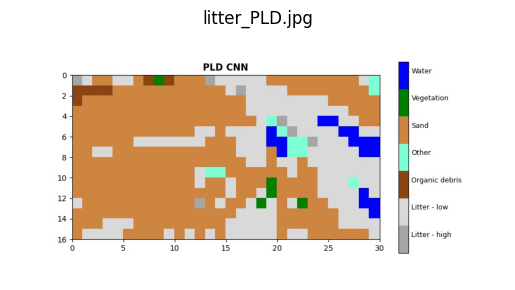

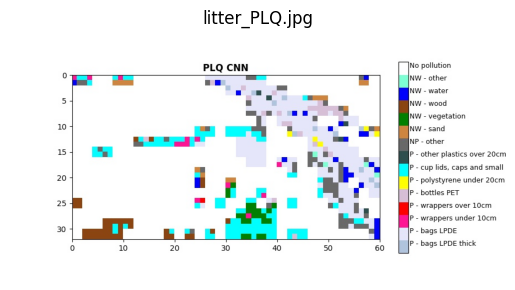

✔️ Archivos guardados en: output/tmplxq6mqxj


In [29]:
print("Waiting for new .zip file in {bucket_name}/{prefix}...")
initial_obj = get_latest_zip_object()
last_seen_key = initial_obj.object_name if initial_obj else None
last_seen_time = initial_obj.last_modified if initial_obj else None

while True:
    latest_obj = get_latest_zip_object()
    if latest_obj:
        new_key = latest_obj.object_name
        new_time = latest_obj.last_modified
        if new_key != last_seen_key or new_time != last_seen_time:
            print(f"File Detected: {new_key}")
            local_zip_path = os.path.join(download_dir, os.path.basename(new_key))
            client.fget_object(bucket_name, new_key, local_zip_path)
            print(f"Save in: {local_zip_path}")
            process_zip(local_zip_path,output)
            break
    time.sleep(5)
os.remove(local_zip_path)